# Домашнее задание 3. Pandas (HW)

## ЗАДАЧА

В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. Такие данные могут быть использованы для построения персонализированных ИИ-ассистентов для поддержки обучения студента. На текущем этапе сосредоточимся на начальном этапе — сборе и подготовке данных.

## ВАМ НЕОБХОДИМО:

* Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

## РЕСУРСЫ:

[Данные на Kaggle](https://www.kaggle.com/competitions/riiid-test-answer-prediction/data)

[Данные для скачивания](https://drive.google.com/drive/folders/1k0k3d-WO9kYqp0q9QG1WcmLn6mWWs0Zd?usp=sharing)

Результат прислать в формате ссылки на Github с ноутбуком

## ОПИСАНИЕ ДАННЫХ

Для выполнения задания вам необходимы файлы train.csv, lectures.csv, questions.csv.

**TRAIN.CSV**

* **row_id: (int64)** порядковый номер строки в этой таблице.* **timestamp: (int64)** время в миллисекундах между текущим взаимодействием и первым событием связанным с данным ученика.
* **user_id: (int32)** идентификационный код ученика.
* **content_id: (int16)** идентификационный код вопроса или лекции.
* **content_type_id: (int8)** 0 если это вопрос, 1 если лекция.
* **task_container_id: (int16)** идентификационный код группы вопросов, в которой задан текущий вопрос.
* **user_answer: (int8)** вариант ответа, который выбрал ученик. Всего вариантов может быть 4. В случае если взаимодействие - это лекция, а не вопрос, то данное поле равно -1.
* **answered_correctly: (int8)** правильно ли ученик ответил на вопрос. В случае, если взаимодействие - это лекция, а не вопрос, то данное поле равно -1.
* **prior_question_elapsed_time: (float32)** среднее время в миллисекундах, которое ученику потребовалось, чтобы ответить на все вопросы в предыдущей группе, игнорируя любые лекции между ними. Равен 0 для первой группы вопросов, заданной ученику.
* **prior_question_had_explanation: (bool)** смотрел ли ученик объяснение и правильный ответ на предыдущий вопрос.й вопрос.

**QUESTIONS.CSV**

* **question_id:** внешний ключ(foreign key) для связывание данной информации с таблицей train. - соответствует content_id
* **bundle_id:** код по которому вопросы объединяются в группы.
* **correct_answer:** правильный ответ на вопрос.(Можно использовать для проверки правильности user_answer)
* **part:** один из семи типов вопросов [TOEIC](https://www.iibc-global.org/english/toeic/test/lr/about/format.html). 
* **tags:** один или несколько кодов с тэгами для данного вопроса. Описание тэгов не представлено, но самих кодов достаточно для того, чтобы сделать кластеризацию.

**LECTURES.CSV**

* **lecture_id:** внешний ключ(foreign key) для связывание данной информации с таблицей train. - соответствует content_id
* **type_of:** краткое описание основной цели лекции. ('concept', 'solving question', 'intention', 'starter')
* **part:** один из семи типов, который был в таблице с вопросами. (код темы/раздела 7 тем)
* **tag:** один тэг в качестве числа, который представляет лекцию, его значение не дано, также как и в вопросах. (можно использовать для кластеризации лекций 151 тип)

## Решение поставленной задачи

### Импорт требуемых библиотек

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

### 0. Загрузка данных

In [22]:
train = pd.read_csv('data/train.csv', sep=',', index_col=0)
questions = pd.read_csv('data/questions.csv', sep=',')
lectures = pd.read_csv('data/lectures.csv', sep=',')

# Оптимизированная загрузка даххын
# train = pd.read_csv('data/train.csv', 
#                     sep=',', 
#                     index_col=0,
#                     dtype = {'row_id': 'int64', 
#                              'timestamp': 'int64', 
#                              'user_id': 'int32', 
#                              'content_id': 'int16', 
#                              'content_type_id': 'int8', 
#                              'task_container_id': 'int16', 
#                              'user_answer': 'int8', 
#                              'answered_correctly': 'int8', 
#                              'prior_question_elapsed_time': 'float32', 
#                              'prior_question_had_explanation': 'boolean'
#                             }
#                    )
# questions = pd.read_csv('data/questions.csv', 
#                         sep=',',
#                         dtype = {'question_id': 'int16', 
#                                  'bundle_id': 'int16', 
#                                  'correct_answer': 'int8',
#                                  'part': 'int8', 
#                                  'tags': 'object'
#                                }
#                        )
# lectures = pd.read_csv('data/lectures.csv',  
#                        sep=',',
#                        dtype = {'lecture_id': 'int16', 
#                                 'tag': 'int16', 
#                                'part': 'int8', 
#                                 'type_of': 'object'
#                                }
#                       )

In [23]:
train.head(3)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,NaN
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False


In [24]:
questions.head(3)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92


In [25]:
lectures.head(3)

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept


### 1. Первичный обзор данных

In [27]:
# Возвращает краткую информацию о датафрейме df
def info_check(df):
    print("Краткая информация о днных:")
    display(df.info())
    print("Сводная статистика числовых данных:")
    display(df.describe().T)
    print("Сводная статистика для строковых данных:")
    display(df.describe(include = 'object').T)
    print('Всего дубликатов в файле:',df.duplicated().sum(),'\n')
    print('Всего пропусков в файле:','\n'*2,df.isna().sum(),'\n')

#### TRAIN

In [29]:
info_check(train)

Краткая информация о днных:
<class 'pandas.core.frame.DataFrame'>
Index: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int64  
 2   content_id                      int64  
 3   content_type_id                 int64  
 4   task_container_id               int64  
 5   user_answer                     int64  
 6   answered_correctly              int64  
 7   prior_question_elapsed_time     float64
 8   prior_question_had_explanation  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 7.5+ GB


None

Сводная статистика числовых данных:


,count,mean,std,min,25%,50%,75%,max
timestamp,101230332.0,7.703644e+09,1.159266e+10,0.0,524343559.0,2.674234e+09,9.924551e+09,8.742577e+10
user_id,101230332.0,1.076732e+09,6.197163e+08,115.0,540811564.0,1.071781e+09,1.615742e+09,2.147483e+09
content_id,101230332.0,5.219605e+03,3.866359e+03,0.0,2063.0,5.026000e+03,7.425000e+03,3.273600e+04
content_type_id,101230332.0,1.935222e-02,1.377596e-01,0.0,0.0,0.000000e+00,0.000000e+00,1.000000e+00
task_container_id,101230332.0,9.040624e+02,1.358302e+03,0.0,104.0,3.820000e+02,1.094000e+03,9.999000e+03
user_answer,101230332.0,1.376123e+00,1.192896e+00,-1.0,0.0,1.000000e+00,3.000000e+00,3.000000e+00
answered_correctly,101230332.0,6.251644e-01,5.225307e-01,-1.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00
prior_question_elapsed_time,98878794.0,2.542381e+04,1.994815e+04,0.0,16000.0,2.100000e+04,2.966600e+04,3.000000e+05


Сводная статистика для строковых данных:


,count,unique,top,freq
prior_question_had_explanation,100837826,2,True,89685560


Всего дубликатов в файле: 135 

Всего пропусков в файле: 

 timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64 



#### QUESTIONS

In [31]:
info_check(questions)

Краткая информация о днных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


None

Сводная статистика числовых данных:


,count,mean,std,min,25%,50%,75%,max
question_id,13523.0,6761.000000,3903.898180,0.0,3380.5,6761.0,10141.5,13522.0
bundle_id,13523.0,6760.510907,3903.857783,0.0,3379.5,6761.0,10140.0,13522.0
correct_answer,13523.0,1.455298,1.149707,0.0,0.0,1.0,3.0,3.0
part,13523.0,4.264956,1.652553,1.0,3.0,5.0,5.0,7.0


Сводная статистика для строковых данных:


,count,unique,top,freq
tags,13522,1519,8,738


Всего дубликатов в файле: 0 

Всего пропусков в файле: 

 question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64 



#### Lectures

In [33]:
info_check(lectures)

Краткая информация о днных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


None

Сводная статистика числовых данных:


,count,mean,std,min,25%,50%,75%,max
lecture_id,418.0,16983.401914,9426.164660,89.0,9026.25,17161.5,24906.25,32736.0
tag,418.0,94.480861,53.586487,0.0,50.25,94.5,140.00,187.0
part,418.0,4.267943,1.872424,1.0,2.00,5.0,6.00,7.0


Сводная статистика для строковых данных:


,count,unique,top,freq
type_of,418,4,concept,222


Всего дубликатов в файле: 0 

Всего пропусков в файле: 

 lecture_id    0
tag           0
part          0
type_of       0
dtype: int64 



#### Вывод:

* Во всех таблицах требуется изменить типы данных, для уменьшения объёма используемой памяти.
* Отсутсвуют полные дубликаты.
* В файле Train есть пропуски в столбцах prior_question_elapsed_time, prior_question_had_explanation.
* В столбце questions['tags'] также есть один пропуск.
* Столбцу lectures['type_of'] можно задать тип category.
* В файле questions столбец tags имеет тип данных object, хотя представлены данные числовыми кодами.
* В файле train в столбце 'prior_question_had_explanation' имеют тип object, хотя значения булевы.
* Столбцам train['timestamp'] и train['prior_question_elapsed_time'] можно задать тип timedelta.

### 2. Предобработка данных

#### Преобразование типов данных

In [38]:
"""
Посчитаем начальный объём занимаемой памяти датайфремом train
"""
memory_train_start = train.memory_usage(index=True, deep=True).sum()
memory_train_start

10931305832

In [39]:
train = train.astype({
              'timestamp': 'int64', 
              'user_id': 'int32', 
              'content_id': 'int16', 
              'content_type_id': 'int8', 
              'task_container_id': 'int16', 
              'user_answer': 'int8', 
              'answered_correctly': 'int8', 
              'prior_question_elapsed_time': 'float32', 
              'prior_question_had_explanation': 'boolean'
             })

In [40]:
"""
Посчитаем объём занимаемой памяти датайфремом train, после преобразований
"""
memory_train_finish = train.memory_usage(index=True, deep=False).sum()
memory_train_finish

3340600956

In [41]:
print(f'{memory_train_start - memory_train_finish} байт - кол-во байт на которые удалось сократить занимаемый объём памяти датайремом train')

7590704876 байт - кол-во байт на которые удалось сократить занимаемый объём памяти датайремом train


In [42]:
"""
Посчитаем начальный объём занимаемой памяти датайфремом questions
"""
memory_questions_start = questions.memory_usage(index=True, deep=True).sum()
memory_questions_start

1292097

In [43]:
questions = questions.astype({'question_id': 'int16', 
                                 'bundle_id': 'int16', 
                                 'correct_answer': 'int8',
                                 'part': 'int8', 
                                 'tags': 'object'
                               })

In [44]:
"""
Посчитаем объём занимаемой памяти датайфремом questions, после преобразований
"""
memory_questions_finish = questions.memory_usage(index=True, deep=False).sum()
memory_questions_finish

189454

In [45]:
print(f'{memory_questions_start - memory_questions_finish} байт - кол-во байт на которые удалось сократить занимаемый объём памяти датайремом questions')

1102643 байт - кол-во байт на которые удалось сократить занимаемый объём памяти датайремом questions


In [46]:
"""
Посчитаем начальный объём занимаемой памяти датайфремом lectures
"""
memory_lectures_start = lectures.memory_usage(index=True, deep=True).sum()
memory_lectures_start

38604

In [47]:
lectures = lectures.astype({'lecture_id': 'int16', 
                            'tag': 'int16', 
                            'part': 'int8', 
                            'type_of': 'category'
                            })

In [48]:
"""
Посчитаем объём занимаемой памяти датайфремом train, после преобразований
"""
memory_lectures_finish = lectures.memory_usage(index=True, deep=False).sum()
memory_lectures_finish

2844

In [49]:
print(f'{memory_lectures_start - memory_lectures_finish} байт - кол-во байт на которые удалось сократить занимаемый объём памяти датайремом lectures')

35760 байт - кол-во байт на которые удалось сократить занимаемый объём памяти датайремом lectures


#### Обработка пропусков

In [51]:
"""
Определим долю пропусков в столбце 'prior_question_had_explanation' датафрейма train
"""
print(f"Доля пропусков в столбце 'prior_question_had_explanation' датафрейма train составляет:\
 {round(train['prior_question_had_explanation'].isna().sum()/train['prior_question_had_explanation'].shape[0]*100,3)}%")

Доля пропусков в столбце 'prior_question_had_explanation' датафрейма train составляет: 0.388%


In [52]:
"""
Определим соотношение значений в столбце 'prior_question_had_explanation' датафрейма train
"""
display(train['prior_question_had_explanation'].value_counts(normalize = True))

prior_question_had_explanation
True     0.889404
False    0.110596
Name: proportion, dtype: Float64

In [53]:
"""
В 89% случаев занчение True, поэтому преобразуем пустые значение в Trueи для удобства анализа преобразуем данный столбец к числотову типу данных
"""
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].fillna(True)
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('int8')

In [54]:
"""
Определим долю пропусков в столбце 'prior_question_elapsed_time' датафрейма train
"""
print(f"Доля пропусков в столбце 'prior_question_elapsed_time' датафрейма train составляет:\
 {round((train['prior_question_elapsed_time'].isna().sum())/(train['prior_question_elapsed_time'].shape[0])*100,3)}%")

Доля пропусков в столбце 'prior_question_elapsed_time' датафрейма train составляет: 2.323%


In [55]:
"""
Согласно условиям в данном столбце 0 соответсвует первой группе вопросов, заданной ученику. Проверим наличие нулей в колонке.
"""
if train['prior_question_elapsed_time'].min() == 0:
    print("В столбце есть нули")
else:
    print("В столбце отсутсвуют нули")

В столбце есть нули


In [56]:
print(f'Всего пропусков в столбце "prior_question_elapsed_time" : {train["prior_question_elapsed_time"].isna().sum()}')

Всего пропусков в столбце "prior_question_elapsed_time" : 2351538


In [57]:
print(f'Всего пропусков вызывано тем, что вопрос первый: {train.query("content_type_id == 0 & content_type_id==0")["prior_question_elapsed_time"].isna().sum()}')

Всего пропусков вызывано тем, что вопрос первый: 392506


In [58]:
"""
Относительн общего кол-ва впоросов первых вопросов мало, поэтому сделаем вывод, что пропуски явялются первыми вопросами
"""
train["prior_question_elapsed_time"] = train["prior_question_elapsed_time"].fillna(0)

In [59]:
"""
Определим долю пропусков в столбце 'tags' датафрейма questions
"""
print(f"Доля пропусков в столбце 'tags' датафрейма questions составляет:\
 {round((questions['tags'].isna().sum())/(questions['tags'].shape[0])*100,5)}%")

Доля пропусков в столбце 'tags' датафрейма questions составляет: 0.00739%


In [60]:
"""
Доля пропусков в столбце 'tags' датафрейма questions соствляет всего 0.00739% от общего кол-ва, поэтому удалим аднныю часть данных
"""
questions = questions.dropna(subset = 'tags')

In [61]:
"""
Измение типа данных для временных интервалов с числового на timedelta
"""
train['timestamp'] = train['timestamp'].apply(lambda x: timedelta(milliseconds = x))

train['prior_question_elapsed_time'] = (
    train['prior_question_elapsed_time'].apply(lambda x: timedelta(milliseconds = x))
)

### 3. Исследуем данные

#### Train

In [64]:
train.head(3)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0 days 00:00:00,115,5692,0,1,3,1,0 days 00:00:00,1
1,0 days 00:00:56.943000,115,5716,0,2,2,1,0 days 00:00:37,0
2,0 days 00:01:58.363000,115,128,0,0,0,1,0 days 00:00:55,0


In [65]:
"""
Исследуем кол-во уникальных значений для разных колонок датайрема train
"""
unique_list = []
for col in train.columns:
    item = (col, train[col].nunique(), train[col].dtype)
    unique_list.append(item)
unique_df = pd.DataFrame(data = unique_list, columns = ['Column_Name', 'Num_Unique', 'Type']).sort_values(by = 'Num_Unique', ascending = True, ignore_index = True)
display(unique_df)

,Column_Name,Num_Unique,Type
0,content_type_id,2,int8
1,prior_question_had_explanation,2,int8
2,answered_correctly,3,int8
3,user_answer,5,int8
4,prior_question_elapsed_time,3258,timedelta64[ns]
5,task_container_id,10000,int16
6,content_id,13782,int16
7,user_id,393656,int32
8,timestamp,72821015,timedelta64[ns]


Данные с небольшим кол-вом уникальных значений рассмотрим подробно.

In [67]:
"""
Начнем с типов активности: 0 - вопрос(ы), 1 - лекция
"""
train['content_type_id'].value_counts(normalize = True)

content_type_id
0    0.980648
1    0.019352
Name: proportion, dtype: float64

98% активности пользователей приходится на ответы на вопросы и лишь 2% на изучение лекций.

In [69]:
print(f"Общее кол-во ответов на вопросы составляет: {train['content_type_id'].value_counts()[0]}")
print(f"Общее кол-во изчения лекций составляет: {train['content_type_id'].value_counts()[1]}")

Общее кол-во ответов на вопросы составляет: 99271300
Общее кол-во изчения лекций составляет: 1959032


In [70]:
"""
Исследуем соотношение правильных и неправильных ответов
"""
train_question = train['answered_correctly'] != -1
train[train_question]['answered_correctly'].value_counts(normalize=True) 

answered_correctly
1    0.657236
0    0.342764
Name: proportion, dtype: float64

66% составялют праивльнгые ответы и 34% - непраивльные ответы.

In [72]:
print(f"Общее кол-во правильных ответов составляет: {train[train_question]['answered_correctly'].value_counts()[0]}")
print(f"Общее кол-во неправильных ответов составляет: {train[train_question]['answered_correctly'].value_counts()[1]}")

Общее кол-во правильных ответов составляет: 34026673
Общее кол-во неправильных ответов составляет: 65244627


In [73]:
"""
Посчитаем среднее время на решение вопроса
"""
print(f"Среднее время на решениие вопроса составялет: {train['prior_question_elapsed_time'].mean()}")

Среднее время на решениие вопроса составялет: 0 days 00:00:24.833225637


In [74]:
train[train_question][['prior_question_elapsed_time', 'answered_correctly']].groupby('answered_correctly').mean()

,prior_question_elapsed_time
answered_correctly,
0,0 days 00:00:25.547366927
1,0 days 00:00:25.206424668


Время ответа не влияет на его правильность.

In [76]:
print(f"Среднее кол-во вопросов на которые дал ответ каждый пользователь: {train[train['content_type_id'] == 0].shape[0] / train['user_id'].nunique()}")
print(f"Среднее кол-во правильных ответов, данных каждым пользователем: {train[train_question]['answered_correctly'].sum() / train['user_id'].nunique()}")
print(f"Среднее кол-во просмотренных лекций, каждым пользователем: {train[train['content_type_id'] == 1].shape[0] / train['user_id'].nunique()}")

Среднее кол-во вопросов на которые дал ответ каждый пользователь: 252.17778974536142
Среднее кол-во правильных ответов, данных каждым пользователем: 165.74020718596947
Среднее кол-во просмотренных лекций, каждым пользователем: 4.976507407482675


In [77]:
"""
Зависимость между правильностью ответа и времени после начала сессии
"""
train[train_question][['timestamp', 'answered_correctly']].groupby('answered_correctly').describe()

timestamp                              \
                       count                        mean   
answered_correctly                                         
0                   34026673  83 days 17:55:10.636627403   
1                   65244627  91 days 23:01:09.866050452   

                                                                  \
                                            std              min   
answered_correctly                                                 
0                   131 days 20:19:28.370550416  0 days 00:00:00   
1                   135 days 07:51:20.289665736  0 days 00:00:00   

                                                                     \
                                       25%                      50%   
answered_correctly                                                    
0                   3 days 20:10:24.602000  26 days 06:23:48.881000   
1                   7 days 05:07:11.912000  33 days 07:33:43.598000   

                                                                         
                                         75%                        max  
answered_correctly                                                       
0                   104 days 00:12:42.450000  1009 days 04:22:35.096000  
1                   120 days 08:52:42.688000  1011 days 20:56:12.049000

Чем ближе к началу сессии вопрос, тем менее успешно его проходят студенты (т.е. успешность коррелирует со временем, проведенным на платформе)

In [79]:
"""
Зависимость между правильностью ответа и видел лт велочек ответ и объяснения к прошлому вопросу
"""
train[train_question][['prior_question_had_explanation', 'answered_correctly']].groupby('answered_correctly').mean()

,prior_question_had_explanation
answered_correctly,
0,0.865081
1,0.929459


Если студент видел объяснение предыдущий задачи, он в 2 раза чаще отвечает правильно, чем неправильно

In [81]:
"""
Количество уникальных вопросов присутсвующих в группе вопросов.
"""
fig_1 = (
    train.query('content_type_id == 0').groupby('task_container_id')['content_id'].nunique()
)
fig_1

task_container_id
0       5194
1       6206
2       4856
3       5949
4       5760
        ... 
9995     189
9996     180
9997     183
9998     183
9999     170
Name: content_id, Length: 10000, dtype: int64

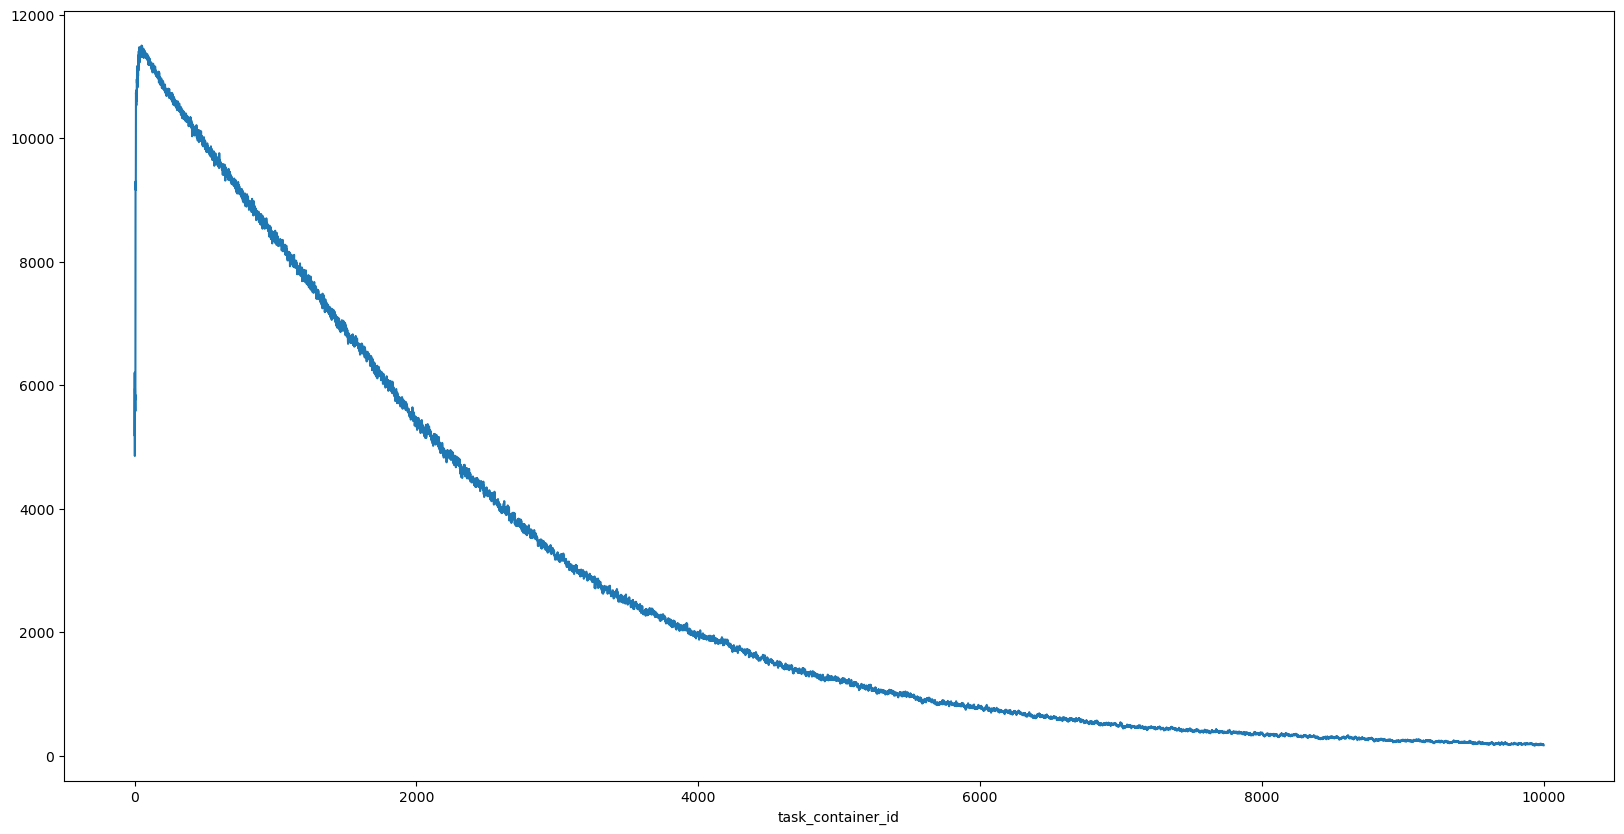

In [82]:
fig_1.plot(
    x = 'task_container_id',
    y = 'content_id',
    figsize = (20, 10)
)
plt.show()

In [83]:
train['timestamp'].dt.days.describe()

count    1.012303e+08
mean     8.871596e+01
std      1.341382e+02
min      0.000000e+00
25%      6.000000e+00
50%      3.000000e+01
75%      1.140000e+02
max      1.011000e+03
Name: timestamp, dtype: float64

<Axes: title={'center': 'Распределение времни взаимодествий студентов от начала сессии до текущего взаимодествия'}, xlabel='Количество дней', ylabel='Количество взаимодействий студентов'>

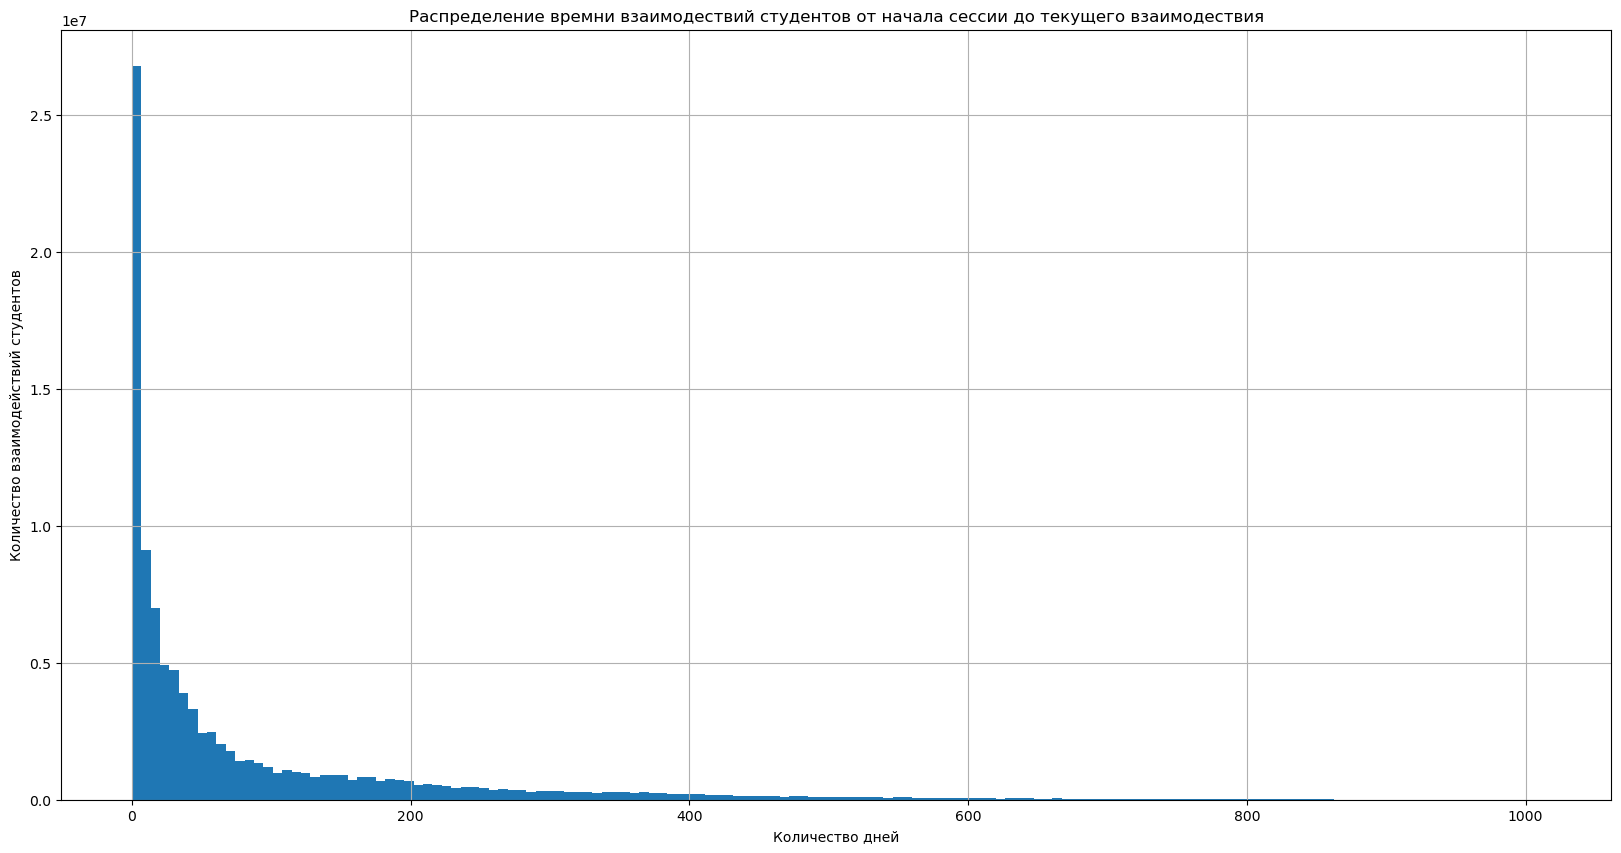

In [84]:
plt.figure(figsize=(20, 10))
plt.xlabel('Количество дней')
plt.ylabel('Количество взаимодействий студентов')
plt.title('Распределение времни взаимодествий студентов от начала сессии до текущего взаимодествия')
train['timestamp'].dt.days.hist(bins = 150)

**Вывод:**

* Всего в данных присутствует информация об активности 393656 студентов.
* На платформе 13523 вопросов (объединенных в 10000 блоков) и 418 лекций по 7 темам.
* 98% активности пользователей приходится на ответы на вопросы и лишь 2% на изучение лекций.
* 66% составялют праивльнгые ответы и 34% - непраивльные ответы.
* Среднее время на решениие вопроса составялет 24.83 секунды.
* Среднее время ответа не стильно влияет на его правильность.
* Среднее кол-во вопросов на которые дал ответ каждый пользователь: 252
* Среднее кол-во правильных ответов, данных каждым пользователем: 165.74
* Среднее кол-во просмотренных лекций, каждым пользователем: 4.97
* Чем ближе к началу сессии вопрос, тем менее успешно его проходят студенты (т.е. успешность коррелирует со временем, проведенным на платформе).
* Если студент видел объяснение предыдущий задачи, он на 7% отвечает правильнее.
* Также мы  видим изначлаьно резкий скачёк уникальных вопросов, но полсе общее снижении уникальности вопросов в завсисимоти от группы вопросов.
* Большинство студентов взаимодействуют активно в первые дни после начала сессии, и их активность со временем снижается.

#### QUESTIONS

In [88]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13522 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13522 non-null  int16 
 1   bundle_id       13522 non-null  int16 
 2   correct_answer  13522 non-null  int8  
 3   part            13522 non-null  int8  
 4   tags            13522 non-null  object
dtypes: int16(2), int8(2), object(1)
memory usage: 290.5+ KB


In [89]:
"""
Исследуем кол-во уникальных значений для разных колонок
"""

unique_list = []
for col in questions.columns:
    item = (col, questions[col].nunique(), questions[col].dtype)
    unique_list.append(item)
unique_df = pd.DataFrame(data = unique_list, columns = ['Column_name', 'Num_unique', 'Col_type']).sort_values(by = 'Num_unique', ignore_index = True)
display(unique_df)

,Column_name,Num_unique,Col_type
0,correct_answer,4,int8
1,part,7,int8
2,tags,1519,object
3,bundle_id,9764,int16
4,question_id,13522,int16


In [90]:
questions['question_id'].groupby(questions['bundle_id']).describe()

,count,mean,std,min,25%,50%,75%,max
bundle_id,,,,,,,,
0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0
2,1.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0
3,1.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0
4,1.0,4.0,NaN,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...
13518,1.0,13518.0,NaN,13518.0,13518.0,13518.0,13518.0,13518.0
13519,1.0,13519.0,NaN,13519.0,13519.0,13519.0,13519.0,13519.0
13520,1.0,13520.0,NaN,13520.0,13520.0,13520.0,13520.0,13520.0


In [91]:
questions['question_id'].groupby(questions['bundle_id']).count().value_counts().sort_values()

question_id
2      71
5     111
4     379
3    1053
1    8150
Name: count, dtype: int64

In [92]:
questions['question_id'].groupby(questions['bundle_id']).count().value_counts(normalize=True).sort_values()

question_id
2    0.007272
5    0.011368
4    0.038816
3    0.107845
1    0.834699
Name: proportion, dtype: float64

Большая часть вопросов (9764) объединяется в группы для совместнойо отдачи, таких групп 5. 1 группа составлеят 83,5%; 2 - 0,7%; 3 - 10,8%; 4 - 3,9%; 5 - 1,1%.

In [94]:
"""
Номера разделов в тесте TOEIC.
"""
questions['part'].value_counts(normalize=True).sort_values()

part
1    0.073362
7    0.085786
6    0.089558
4    0.106419
3    0.115515
2    0.121802
5    0.407558
Name: proportion, dtype: float64

Вопросы разделены по темам на 7 разделов. Разделы соствляют: 5 - 40,7%; 2 - 12,2%; 3 - 11,6%; 4 - 10,6%; 6 - 8,9%; 7 - 8,6%; 1 - 7,4%.

In [96]:
"""
Кодировка типа вопроса.
"""
questions['tags'].describe()

count     13522
unique     1519
top           8
freq        738
Name: tags, dtype: object

Кол-во уникльных кодировок по типу вопроса соталяет 1519 и наиболее попклярным - является 8ая кодировка.

In [98]:
tags = set()
for tag in questions['tags']:
    try:
        for t in tag.split():
            tags.add(int(t))
    except:
        tags.add(int(tag))
print(f"Кол-во уникальных  кодировок составляет - {len(tags)}")

Кол-во уникальных  кодировок составляет - 188


In [99]:
"""
Создадим таблицу обобщающую информацию из таблиц questions и train
"""
tmp_df = train.loc[(train['content_type_id'] == 0), ['content_id', 'answered_correctly']]
tmp_df.value_counts()

content_id  answered_correctly
6116        0                     153992
7900        1                     149422
2063        0                     147327
4120        0                     144428
6173        0                     142400
                                   ...  
13159       0                          1
7546        0                          1
8129        0                          1
12803       0                          1
10008       1                          1
Name: count, Length: 27025, dtype: int64

In [214]:
train_for_questions = (
    train.query('content_type_id == 0').groupby('content_id')['answered_correctly'].agg(['count', 'sum'])
)
train_for_questions.columns = ['overall_answers', 'correct_answers']
train_for_questions = train_for_questions.rename_axis('question_id')
train_for_questions

,overall_answers,correct_answers
question_id,,
0,6903,6266
1,7398,6589
2,44905,24890
3,22973,17906
4,31736,19461
...,...,...
13518,868,683
13519,924,528
13520,861,579


In [215]:
train_for_questions['success_rate'] = (train_for_questions['correct_answers']/train_for_questions['overall_answers'])
train_for_questions

,overall_answers,correct_answers,success_rate
question_id,,,
0,6903,6266,0.907721
1,7398,6589,0.890646
2,44905,24890,0.554281
3,22973,17906,0.779437
4,31736,19461,0.613215
...,...,...,...
13518,868,683,0.786866
13519,924,528,0.571429
13520,861,579,0.672474


In [216]:
train_for_questions.describe()

,overall_answers,correct_answers,success_rate
count,13523.000000,13523.000000,13523.000000
mean,7340.922872,4824.715448,0.709460
std,11455.927774,6419.482619,0.164486
min,1.000000,0.000000,0.000000
25%,1765.500000,1274.000000,0.609345
50%,4732.000000,3236.000000,0.734215
75%,8556.000000,5877.500000,0.835116
max,213605.000000,149422.000000,1.000000


In [224]:
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [234]:
questions_for_train = pd.merge(questions, train_for_questions, how='inner',  on='question_id')
questions_for_train = questions_for_train.drop(['correct_answer', 'bundle_id'], axis=1)
questions_for_train.head(3)

,question_id,part,tags,overall_answers,correct_answers,success_rate
0,0,1,51 131 162 38,6903,6266,0.907721
1,1,1,131 36 81,7398,6589,0.890646
2,2,1,131 101 162 92,44905,24890,0.554281


In [236]:
questions_for_train.describe()

,question_id,part,overall_answers,correct_answers,success_rate
count,13522.000000,13522.000000,13522.000000,13522.000000,13522.000000
mean,6760.758024,4.264828,7341.465686,4825.072179,0.709439
std,3903.941125,1.652547,11456.177487,6419.585961,0.164473
min,0.000000,1.000000,1.000000,0.000000,0.000000
25%,3380.250000,3.000000,1767.500000,1274.000000,0.609343
50%,6760.500000,5.000000,4732.000000,3236.000000,0.734215
75%,10141.750000,5.000000,8556.500000,5877.750000,0.835093
max,13522.000000,7.000000,213605.000000,149422.000000,1.000000


In [254]:
"""
Изучим зависимость правильности ответа от номера раздела в тесте TOEIC ('part')
"""
questions_for_train.groupby('part')['success_rate'].agg('mean').sort_values()

part
5    0.666119
6    0.699348
7    0.717958
4    0.724918
3    0.744598
2    0.745296
1    0.815104
Name: success_rate, dtype: float64

Видим, что по мере продвижения по разделам, сложность возростает, так как колчисетвно праивльных ответов уменьшается.

**Вывод:**

* Большая часть вопросов (9764) объединяется в группы для совместнойо отдачи, таких групп 5. 1 группа составлеят 83,5%; 2 - 0,7%; 3 - 10,8%; 4 - 3,9%; 5 - 1,1%.
* Вопросы разделены по темам на 7 разделов. Разделы соствляют: 5 - 40,7%; 2 - 12,2%; 3 - 11,6%; 4 - 10,6%; 6 - 8,9%; 7 - 8,6%; 1 - 7,4%.
* Кол-во уникльных комбинаций кодировок по типу вопроса соталяет 1519 и наиболее попклярным - является 8ая кодировка.
* Кол-во уникальных  кодировок составляет - 188. (По ним возможно провести клстеризаций)
* В среднем 71% отвечающих на впорос, давали верный ответ.
* Видим, что по мере продвижения по разделам, сложность возростает, так как колчисетвно праивльных ответов уменьшается.

#### LECTURES


In [260]:
lectures.head(3)

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept


In [266]:
"""
Исследуем колонок на кол-во уникальных значений
"""
unique_list = []
for col in lectures.columns:
    item = (col, lectures[col].nunique(), lectures[col].dtype)
    unique_list.append(item)
unique_df = pd.DataFrame(data=unique_list, columns=['Col_name', 'Num_unique', 'Col_type'])

display(unique_df)

,Col_name,Num_unique,Col_type
0,lecture_id,418,int16
1,tag,151,int16
2,part,7,int8
3,type_of,4,category


Всего предсталено 418 лекий 7 типов, которые разбиты на 4 основные цели, а также кажой лекции сапостаялется тэги, предсталвющий лекцию.

In [280]:
"""
Подробно рассмотрим столбец с типами разделов.
"""
lectures['part'].value_counts()

part
5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: count, dtype: int64

In [284]:
lectures['part'].value_counts(normalize = True).sort_values()

part
3    0.045455
4    0.074163
7    0.076555
1    0.129187
2    0.133971
6    0.198565
5    0.342105
Name: proportion, dtype: float64

Лекции разделены на 7 разделов, наиболее число посвещено 5-ому разделу - 34%; 6 - 20%; 2 - 14%; 1 - 13%; 7 - 7,5%; 8 - 7,5%; 3 - 4%.

In [288]:
"""
Подробно рассмотрим столбец с целями лекций.
"""
lectures['type_of'].value_counts()

type_of
concept             222
solving question    186
intention             7
starter               3
Name: count, dtype: int64

In [290]:
lectures['type_of'].value_counts(normalize = True).sort_values()

type_of
starter             0.007177
intention           0.016746
solving question    0.444976
concept             0.531100
Name: proportion, dtype: float64

Леции бывают 4 типов: вступление, целеполагание, концептуальное изложение материала и решение задач.
Большинство лекций посвящены теории (53%), немного меньше - решению задач (44,5%), доля вступительных и целеполагающих лекций незначительна и состялет в сумме всего 2,5%.

In [304]:
"""
Подробно рассмотрим тэги, представляющие лекцию.
"""
lectures['tag'].value_counts()

tag
136    7
27     6
161    6
74     6
134    6
      ..
90     1
112    1
31     1
138    1
2      1
Name: count, Length: 151, dtype: int64

In [306]:
lectures['tag'].value_counts(normalize=True).sort_values()

tag
2      0.002392
17     0.002392
103    0.002392
148    0.002392
83     0.002392
         ...   
134    0.014354
74     0.014354
161    0.014354
27     0.014354
136    0.016746
Name: proportion, Length: 151, dtype: float64

Есть 151 доп.тип лекций, по которым можно провести кластеризацию.

In [411]:
"""
Создадим таблицу обобщающую информацию из таблиц lectures и train
"""
train_for_lectures = (
    train[train['content_type_id'] == 1]
    .groupby('content_id')
    .size()
    .reset_index(name='lecture_count')
    .sort_values(by='lecture_count', ascending=False)
)
train_for_lectures

,content_id,lecture_count
37,3153,37024
260,21411,27051
123,10540,24312
369,29695,24126
188,15888,22627
...,...,...
275,22326,3
359,28569,2
229,18903,2
173,14429,1


In [419]:
lectures_train = pd.merge(train_for_lectures, lectures, left_on='content_id', right_on='lecture_id', how='inner')
lectures_train = lectures_train.drop('content_id', axis = 1)
lectures_train.head()

,lecture_count,lecture_id,tag,part,type_of
0,37024,3153,62,2,intention
1,27051,21411,163,2,solving question
2,24312,10540,99,1,concept
3,24126,29695,27,6,concept
4,22627,15888,26,5,concept


In [421]:
"""
Общий рейтинг популярности для лекций
"""
lectures_train.sort_values(by = 'lecture_count', ascending=False)

,lecture_count,lecture_id,tag,part,type_of
0,37024,3153,62,2,intention
1,27051,21411,163,2,solving question
2,24312,10540,99,1,concept
3,24126,29695,27,6,concept
4,22627,15888,26,5,concept
...,...,...,...,...,...
410,3,22326,182,6,concept
411,2,28569,27,6,starter
412,2,18903,28,6,concept
413,1,14429,25,6,solving question


In [439]:
"""
Рейтинг популярности для лекций, в зависимости от раздела
"""
lectures_train.groupby('part')['lecture_count'].sum().sort_values()

part
7     57030
4     93078
3     99217
1    173057
6    219726
2    382129
5    934795
Name: lecture_count, dtype: int64

In [443]:
n_lectures = lectures_train['lecture_count'].sum()
lectures_train.groupby('part')['lecture_count'].sum().sort_values() / n_lectures

part
7    0.029111
4    0.047512
3    0.050646
1    0.088338
6    0.112160
2    0.195060
5    0.477172
Name: lecture_count, dtype: float64

Наибольшее число просмотренных лекицй было просомтрено по 5 разделу (48%), пототом шли: 2(19.5%), 6(11%), 1(9%), 3(5%), 4(4.5%), 7(3%).

In [448]:
lectures['part'].value_counts()

part
5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: count, dtype: int64

In [456]:
"""
Рейтинг относительной популярности лекций по разделам
"""
for part in range(1, 8):
    print(part, lectures_train.groupby('part')['lecture_count'].sum().sort_values(ascending=False)[part]/lectures_train['part'].value_counts()[part])

1 3204.759259259259
2 6823.732142857143
3 5221.9473684210525
4 3002.516129032258
5 6583.06338028169
6 2712.6666666666665
7 1782.1875


Сильно выделяется равновзвешенная оценка 2 и 5 разделов.

In [471]:
"""
Рейтинг популярности для лекций, в зависимости от тега лекции
"""
lectures_train.groupby('tag')['lecture_count'].sum().sort_values(ascending=False)

tag
62     58869
27     52826
163    41668
136    41483
161    39884
       ...  
143      812
150      748
83       699
171      552
137      300
Name: lecture_count, Length: 151, dtype: int64

In [487]:
"""
Попробуем найти зависимость количества праивльных ответов в зависимости от просмотра лекций.
"""
user_lectures = (train.query('content_type_id == 1').groupby('user_id',as_index = False).agg({'answered_correctly':'count'}))
user_lectures.columns = ['user_id','lectures_answered_correctly']
user_lectures

,user_id,lectures_answered_correctly
0,2746,1
1,5382,3
2,8623,3
3,12741,6
4,13134,7
...,...,...
149601,2147419988,44
149602,2147469944,3
149603,2147470770,2
149604,2147470777,6


In [489]:
users_performance = (train.query('content_type_id == 0').groupby('user_id',as_index = False).agg({'answered_correctly':['sum','count']}))
users_performance.columns = users_performance.columns.droplevel(1)
users_performance.columns = ['user_id','user_correct_answers','user_overall_answers']
users_performance['success_rate'] = (users_performance['user_correct_answers']/users_performance['user_overall_answers'])
users_performance

,user_id,user_correct_answers,user_overall_answers,success_rate
0,115,32,46,0.695652
1,124,7,30,0.233333
2,2746,11,19,0.578947
3,5382,84,125,0.672000
4,8623,70,109,0.642202
...,...,...,...,...
393651,2147470770,173,226,0.765487
393652,2147470777,520,752,0.691489
393653,2147481750,38,50,0.760000
393654,2147482216,177,275,0.643636


In [491]:
user_lectures = pd.merge(users_performance, user_lectures, on='user_id', how='inner')
user_lectures

,user_id,user_correct_answers,user_overall_answers,success_rate,lectures_answered_correctly
0,2746,11,19,0.578947,1
1,5382,84,125,0.672000,3
2,8623,70,109,0.642202,3
3,12741,152,265,0.573585,6
4,13134,878,1243,0.706356,7
...,...,...,...,...,...
149601,2147419988,364,717,0.507671,44
149602,2147469944,200,273,0.732601,3
149603,2147470770,173,226,0.765487,2
149604,2147470777,520,752,0.691489,6


In [497]:
user_lectures['lectures_per_question'] = (user_lectures['lectures_answered_correctly']/(user_lectures['user_overall_answers'] + user_lectures['lectures_answered_correctly']))
user_lectures

,user_id,user_correct_answers,user_overall_answers,success_rate,lectures_answered_correctly,lectures_per_question
0,2746,11,19,0.578947,1,0.050000
1,5382,84,125,0.672000,3,0.023438
2,8623,70,109,0.642202,3,0.026786
3,12741,152,265,0.573585,6,0.022140
4,13134,878,1243,0.706356,7,0.005600
...,...,...,...,...,...,...
149601,2147419988,364,717,0.507671,44,0.057819
149602,2147469944,200,273,0.732601,3,0.010870
149603,2147470770,173,226,0.765487,2,0.008772
149604,2147470777,520,752,0.691489,6,0.007916


In [499]:
user_lectures.describe()

,user_id,user_correct_answers,user_overall_answers,success_rate,lectures_answered_correctly,lectures_per_question
count,1.496060e+05,149606.000000,149606.000000,149606.000000,149606.000000,149606.000000
mean,1.076082e+09,388.078232,579.887077,0.612891,13.094609,0.025064
std,6.203074e+08,781.313166,1099.017897,0.117408,23.755963,0.015298
min,2.746000e+03,1.000000,3.000000,0.043478,1.000000,0.000102
25%,5.387142e+08,51.000000,89.000000,0.546816,1.000000,0.013804
50%,1.076346e+09,134.000000,216.000000,0.630238,4.000000,0.022727
75%,1.613497e+09,377.000000,581.000000,0.695652,13.000000,0.033333
max,2.147482e+09,14300.000000,17609.000000,1.000000,397.000000,0.417808


In [507]:
user_lectures['success_rate'] = (user_lectures['success_rate']*100).round()

In [509]:
user_lectures['lectures_per_question'] = (user_lectures['lectures_per_question']*100).round()

In [527]:
user_lectures_median = user_lectures.groupby('lectures_per_question', as_index = False)['success_rate'].median()
user_lectures_median

,lectures_per_question,success_rate
0,0.0,69.0
1,1.0,66.0
2,2.0,64.0
3,3.0,62.0
4,4.0,60.0
5,5.0,57.0
6,6.0,55.0
7,7.0,51.0
8,8.0,49.0
9,9.0,48.0


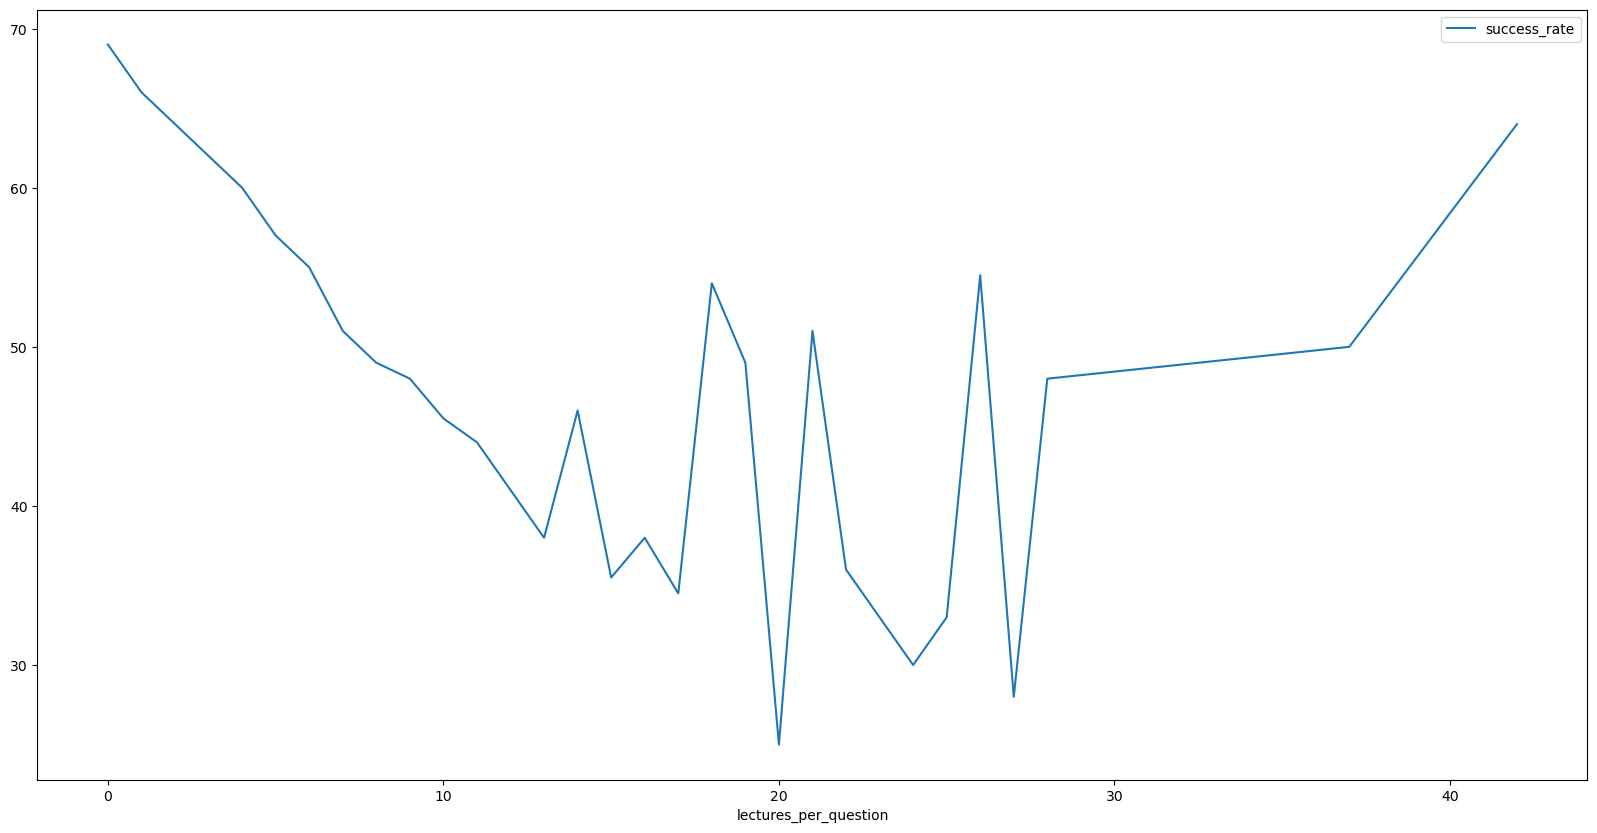

In [529]:
user_lectures_median.plot(
    x = 'lectures_per_question',
    y = 'success_rate',
    figsize = (20, 10)
)
plt.show()

In [547]:
user_lectures_mean = user_lectures.groupby('lectures_per_question', as_index = False)['success_rate'].mean()
user_lectures_mean

,lectures_per_question,success_rate
0,0.0,68.623052
1,1.0,65.424272
2,2.0,61.976111
3,3.0,59.827659
4,4.0,57.889823
5,5.0,54.987881
6,6.0,53.175035
7,7.0,49.760972
8,8.0,47.834951
9,9.0,46.798206


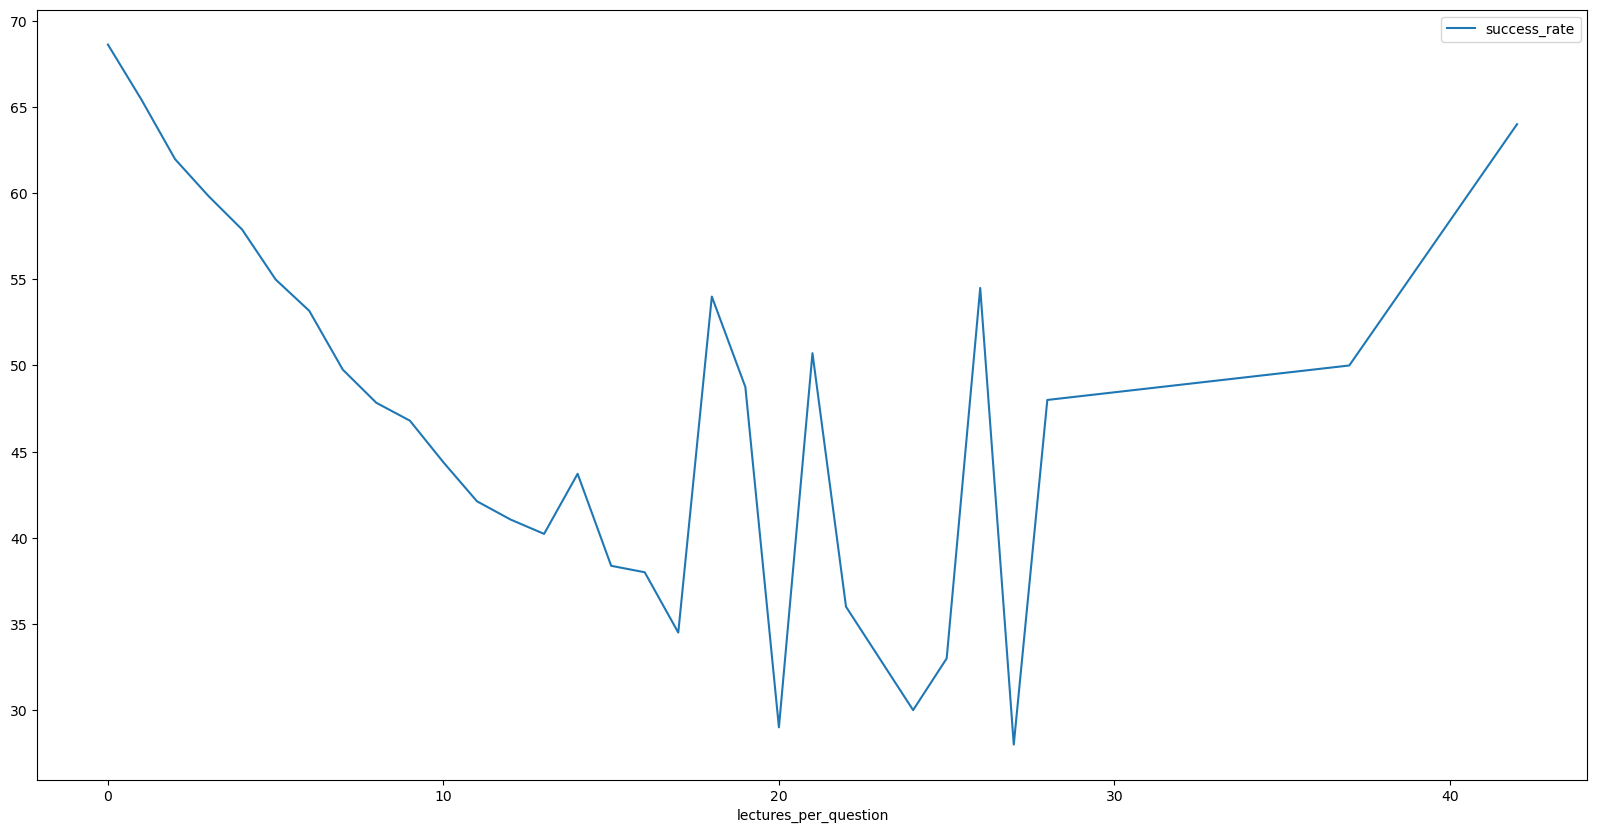

In [549]:
user_lectures_mean.plot(
    x = 'lectures_per_question',
    y = 'success_rate',
    figsize = (20, 10)
)
plt.show()

Мы наблюдаем очень не однозначный результат, так как медианная и средняя доля правильных ответов в зависимости от просмотра лекций в среднем показывают сниждение результатов, это может быть показателем о расхождениях в лекцйионных материалов и проверочных вопросов.

**Вывод:**

* Всего предсталено 418 лекий 7 типов, которые разбиты на 4 основные цели, а также кажой лекции сапостаялется 1 тэг, предсталвющий лекцию.
* Лекции разделены на 7 разделов, наиболее число посвещено 5-ому разделу - 34%; 6 - 20%; 2 - 14%; 1 - 13%; 7 - 7,5%; 8 - 7,5%; 3 - 4%.
* Леции бывают 4 типов: вступление, целеполагание, концептуальное изложение материала и решение задач.
* Большинство лекций посвящены теории (53%), немного меньше - решению задач (44,5%), доля вступительных и целеполагающих лекций незначительна и состялет в сумме всего 2,5%.
* Есть 151 доп.тип лекций, по которым можно провести кластеризацию.
* Наибольшее число просмотренных лекицй было просомтрено по 5 разделу (48%), пототом шли: 2(19.5%), 6(11%), 1(9%), 3(5%), 4(4.5%), 7(3%).
* Сильно выделяется равновзвешенная оценка 2 и 5 разделов.
* Мы наблюдаем очень не однозначный результат, так как медианная и средняя доля правильных ответов в зависимости от просмотра лекций в среднем показывают сниждение результатов, это может быть показателем о расхождениях в лекцйионных материалов и проверочных вопросов.

#### Дополнительные таблицы

##### Агрегируем данные студентов

Cоздадим датафрейм students:

* user_id: ID студента
* time: время, проведенное на платформе
* overall_questions: количество отвеченных вопросов
* average_grade: средний балл студента
* lecture_watched: кол-во просмотренных лекций
* expl_watched: кол-во виденных объяснений на предыдущие вопросы
* average_time_for_question - среднем время, потраченное студентом на каждый вопрос

In [576]:
sudents_list = list(train['user_id'].unique())
print(f'Всего {len(sudents_list)} уникальных студентов')

Всего 393656 уникальных студентов


In [592]:
"""
Посчитаем время на платформе для каждого студента
"""
time = train.groupby('user_id')['timestamp'].sum()
time

user_id
115              54 days 08:55:39.217000
124               0 days 03:03:55.797000
2746              0 days 02:07:43.581000
5382            563 days 03:46:38.787000
8623            451 days 02:17:54.655000
                         ...            
2147470770     3022 days 09:55:14.162000
2147470777   100041 days 09:37:18.755000
2147481750       12 days 16:52:23.963000
2147482216     2781 days 20:26:04.565000
2147482888       83 days 01:31:13.750000
Name: timestamp, Length: 393656, dtype: timedelta64[ns]

In [593]:
"""
Количество отвеченных вопросов
"""
overall_questions = train.query('content_type_id == 0').groupby('user_id')['content_type_id'].count()
overall_questions

user_id
115            46
124            30
2746           19
5382          125
8623          109
             ... 
2147470770    226
2147470777    752
2147481750     50
2147482216    275
2147482888     27
Name: content_type_id, Length: 393656, dtype: int64

In [594]:
"""
Cредний балл студента
"""
average_grade = train.query('content_type_id != -1').groupby('user_id')['answered_correctly'].mean()
average_grade

user_id
115           0.695652
124           0.233333
2746          0.500000
5382          0.632812
8623          0.598214
                ...   
2147470770    0.750000
2147470777    0.678100
2147481750    0.760000
2147482216    0.614286
2147482888    0.555556
Name: answered_correctly, Length: 393656, dtype: float64

In [602]:
"""
Кол-во просмотренных лекций
"""
lecture_watched = train.query('content_type_id == 0').groupby('user_id')['content_type_id'].count()
lecture_watched

user_id
115            46
124            30
2746           19
5382          125
8623          109
             ... 
2147470770    226
2147470777    752
2147481750     50
2147482216    275
2147482888     27
Name: content_type_id, Length: 393656, dtype: int64

In [608]:
"""
Кол-во виденных объяснений на предыдущие вопросы
"""
expl_watched = train.groupby('user_id')['prior_question_had_explanation'].sum()
expl_watched

user_id
115             7
124             1
2746           12
5382          114
8623           97
             ... 
2147470770    196
2147470777    722
2147481750     40
2147482216    267
2147482888     20
Name: prior_question_had_explanation, Length: 393656, dtype: int64

In [609]:
"""
Время, в среднем потраченное студентом на каждый вопрос
"""
average_time_for_question = train.groupby('user_id')['prior_question_elapsed_time'].mean()
average_time_for_question

user_id
115          0 days 00:00:19.499978260
124          0 days 00:00:18.166566666
2746            0 days 00:00:16.250000
5382            0 days 00:00:34.921875
8623            0 days 00:00:25.175000
                        ...           
2147470770   0 days 00:00:22.862548245
2147470777   0 days 00:00:19.843147757
2147481750      0 days 00:00:17.580000
2147482216   0 days 00:00:19.142857142
2147482888   0 days 00:00:26.185185185
Name: prior_question_elapsed_time, Length: 393656, dtype: timedelta64[ns]

* user_id: ID студента
* time: время, проведенное на платформе
* overall_questions: количество отвеченных вопросов
* average_grade: средний балл студента
* lecture_watched: кол-во просмотренных лекций
* expl_watched: кол-во виденных объяснений на предыдущие вопросы
* average_time_for_question - среднем время, потраченное студентом на каждый вопрос

In [647]:
students = pd.DataFrame({'time': time,
                        'overall_questions': overall_questions,
                        'average_grade': average_grade,
                        'lecture_watched': lecture_watched,
                        'expl_watched': expl_watched,
                         'average_time_for_question': average_time_for_question
                       })

In [649]:
students

,time,overall_questions,average_grade,lecture_watched,expl_watched,average_time_for_question
user_id,,,,,,
115,54 days 08:55:39.217000,46,0.695652,46,7,0 days 00:00:19.499978260
124,0 days 03:03:55.797000,30,0.233333,30,1,0 days 00:00:18.166566666
2746,0 days 02:07:43.581000,19,0.500000,19,12,0 days 00:00:16.250000
5382,563 days 03:46:38.787000,125,0.632812,125,114,0 days 00:00:34.921875
8623,451 days 02:17:54.655000,109,0.598214,109,97,0 days 00:00:25.175000
...,...,...,...,...,...,...
2147470770,3022 days 09:55:14.162000,226,0.750000,226,196,0 days 00:00:22.862548245
2147470777,100041 days 09:37:18.755000,752,0.678100,752,722,0 days 00:00:19.843147757
2147481750,12 days 16:52:23.963000,50,0.760000,50,40,0 days 00:00:17.580000


In [651]:
"""
Посмотрим, насколько наша выборка похожа на общие данные:
"""
students.describe()

,time,overall_questions,average_grade,lecture_watched,expl_watched,average_time_for_question
count,393656,393656.000000,393656.000000,393656.000000,393656.000000,393656
mean,3839 days 13:32:51.367091520,252.177790,0.530048,252.177790,228.824319,0 days 00:00:23.024694142
std,19283 days 03:37:00.895415808,734.721108,0.160218,734.721108,719.227403,0 days 00:00:07.655982638
min,-106752 days +19:00:09.702448384,1.000000,-0.142857,1.000000,0.000000,0 days 00:00:00
25%,0 days 03:46:20.834750,30.000000,0.421627,30.000000,7.000000,0 days 00:00:18.426317890
50%,48 days 22:56:48.130000,40.000000,0.550000,40.000000,21.000000,0 days 00:00:21.928253467
75%,1994 days 15:12:30.899500,154.000000,0.647059,154.000000,132.000000,0 days 00:00:26.352941176
max,106747 days 23:25:06.323000,17609.000000,1.000000,17609.000000,17527.000000,0 days 00:03:38.514285714


Данная таблица подтверждаем изученную нами ранее информацию.

<Axes: >

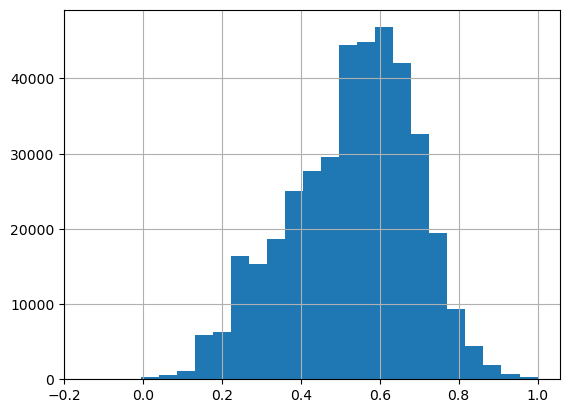

In [666]:
"""
Гистограма распределения средних оценок среди студентов
"""
students['average_grade'].hist(bins = 25)

Гистограмма средняя оценки студентов проказывает высокую плостноть около 0,6 средней оценки у большинстав пользователей, и показатель 0,8 у меньшей части пользхотвателей.

<Axes: xlabel='average_grade', ylabel='time_seconds'>

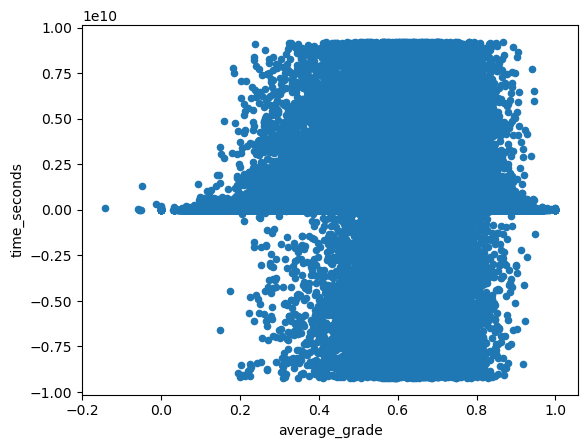

In [677]:
students['time_seconds'] = students['time'].dt.total_seconds()
students.plot.scatter(x = 'average_grade', y = 'time_seconds')

График не показывает явной зависимости можду затраченным временгем на платформе и ростом процента правильнеых ответов у студентов.
Можно предположить, что: - время, проведенное на платформе не имеет значимого влияния на успеваемость;
 - для эффекта нужно затрачивать сильно больше времени, чем большинство студентов;
 - материалы платформы не такого высокого качества.ия)

<Axes: xlabel='average_grade', ylabel='time_seconds'>

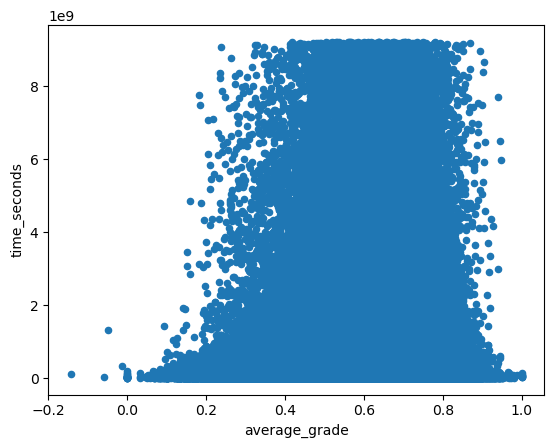

In [694]:
"""
Построим диаграмму рассеяния для студентов, не бросивших учебу в течение 1го часа.
"""
students[students['time_seconds'] > 3000000].plot.scatter(x='average_grade', y='time_seconds')

Теперь уже становится видна тенденция роста успеваемости с течением веремени.

In [700]:
"""
Для наглядности проведем разбиение студентов по временным группам:
 - Добавим столбец с временной группировкой
 - Построим диаграмму размаха
"""
def time_convert(e):
    if e < students['time_seconds'].quantile(0.1): return 0
    elif e < students['time_seconds'].quantile(0.2): return 1
    elif e < students['time_seconds'].quantile(0.3): return 2
    elif e < students['time_seconds'].quantile(0.5): return 4
    elif e < students['time_seconds'].quantile(0.6): return 5
    elif e < students['time_seconds'].quantile(0.7): return 6
    elif e < students['time_seconds'].quantile(0.8): return 7
    elif e < students['time_seconds'].quantile(0.9): return 8
    else: return 9
    
students['time_group'] = students['time_seconds'].apply(time_convert)

<Axes: title={'center': 'average_grade'}, xlabel='time_group'>

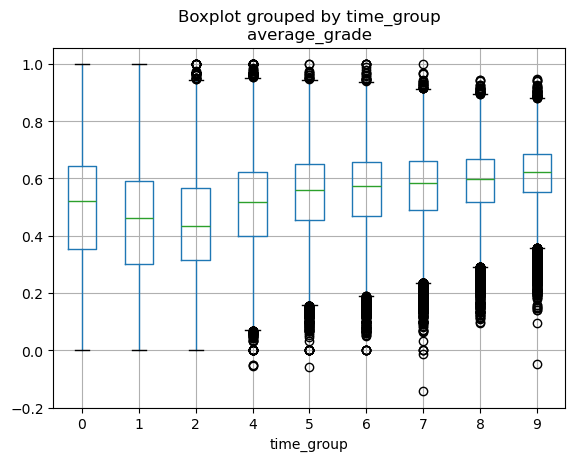

In [702]:
students.boxplot(column = 'average_grade', by = 'time_group')

На этот диаграмме размаха мы видим, что начиная с 4 квартиля проводённое время на платформе начинает положитлеьно влият на среднюю оценку.

<Axes: xlabel='average_grade', ylabel='overall_questions'>

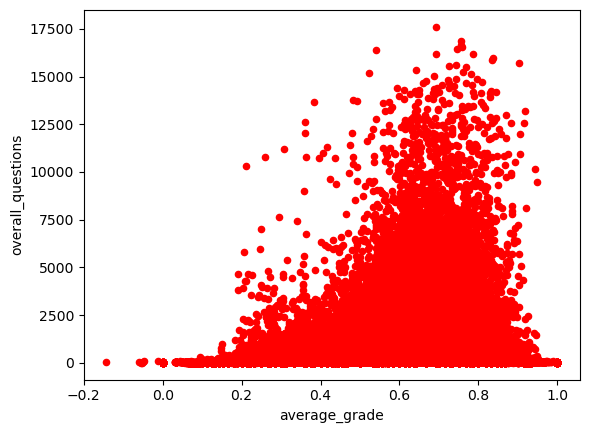

In [703]:
"""
Построим диаграмму рассеяния, показывающую зависимость правильных ответов от кол-ва сделанных заданий.
"""
students.plot.scatter(x = 'average_grade', y = 'overall_questions', c = 'red')

Прослеживается связь между успеваемостью студента и кол-вом отвеченных вопросов.

In [704]:
"""
Построим новый столбец с группировкой по кол-ву отвеченных вопросов
Далее строим диаграмму размаха
"""
def question_convert(e):
    if e < students['overall_questions'].quantile(0.1): return 0
    elif e < students['overall_questions'].quantile(0.2): return 1
    elif e < students['overall_questions'].quantile(0.3): return 2
    elif e < students['overall_questions'].quantile(0.4): return 3
    elif e < students['overall_questions'].quantile(0.5): return 4
    elif e < students['overall_questions'].quantile(0.6): return 5
    elif e < students['overall_questions'].quantile(0.7): return 6
    elif e < students['overall_questions'].quantile(0.8): return 7
    elif e < students['overall_questions'].quantile(0.9): return 8
    else: return 9
    
students['question_group'] = students['overall_questions'].apply(question_convert)

<Axes: title={'center': 'average_grade'}, xlabel='question_group'>

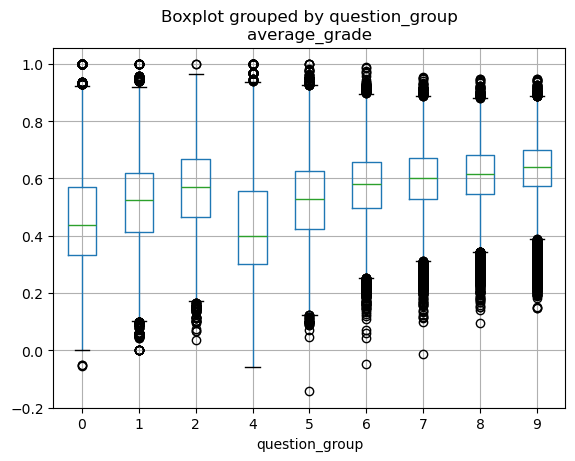

In [705]:
students.boxplot(column = 'average_grade', by = 'question_group')

График группировки по квартилем пказывает постепенный рост успеваемости студента, но 4 квартиль показывает не однознкачсную просадку.

<Axes: xlabel='average_grade', ylabel='lecture_watched'>

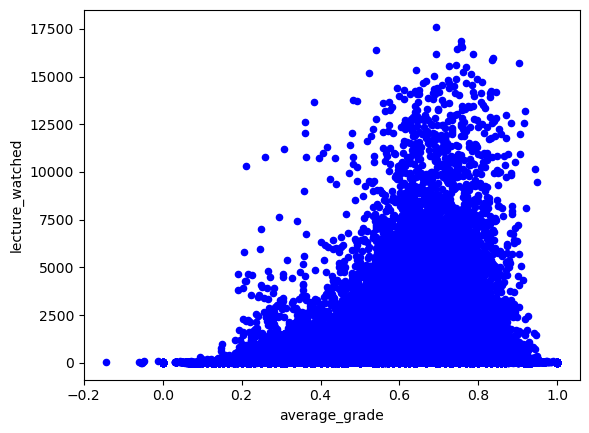

In [701]:
"""
Построим диаграмму рассеяния, показывающую зависимость правильных ответов от кол-ва просмотренных лекций
"""
students.plot.scatter(x = 'average_grade', y = 'lecture_watched', c = 'blue')

Мы видим зависимоть между просмотренными лекциями и средней успеваемостью сиудентов.

<Axes: title={'center': 'average_grade'}, xlabel='[lecture_watched]'>

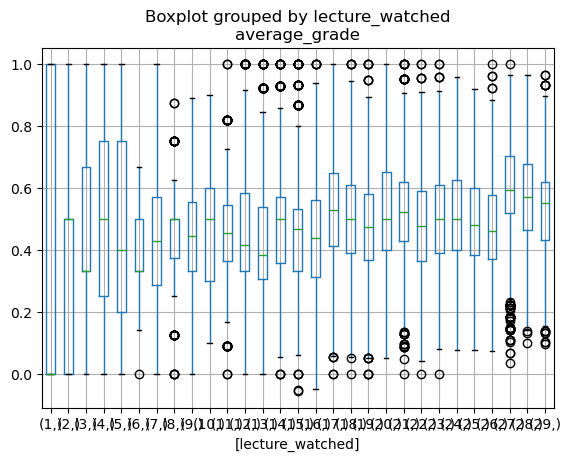

In [733]:
"""
Построим диаграмму размаха, показывающую зависимость правильных ответов от кол-ва просмотренных лекций
"""
students[students['lecture_watched'] < 30].boxplot(column=['average_grade'], by=['lecture_watched'])

Мы видим, что просмотр даже 1 леции повышает средний балл, в 2 лекций значительно повышает минимальную оценку студента.
Максимальный эффект достигается при просмотре 4-11 лекций, после чего эффективность просмотров снижается и становится заметна биже к просмотру 27 лекуций.

<Axes: xlabel='average_grade', ylabel='expl_watched'>

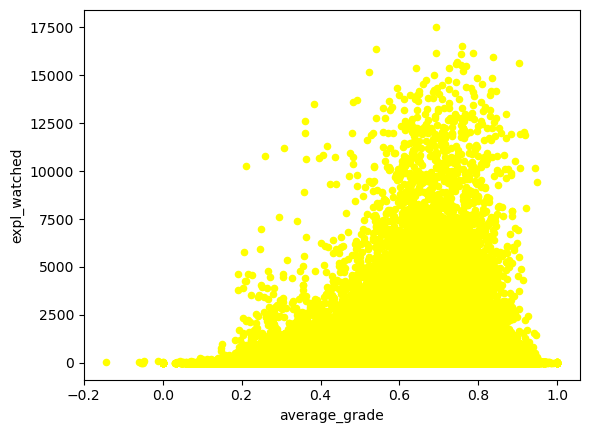

In [707]:
"""
Построим диаграмму рассеяния, показывающую зависимость правильных ответов от кол-ва виденных объяснений.
"""
students.plot.scatter(x = 'average_grade', y = 'expl_watched', c = 'yellow')

Просмотр объяснений очень положительно сказывается на успеваемости студентов.

In [708]:
"""
Построим новый столбец с группировкой по кол-ву правильных ответов.
"""
def expl_convert(e):
    if e < students['expl_watched'].quantile(0.1): return 0
    elif e < students['expl_watched'].quantile(0.2): return 1
    elif e < students['expl_watched'].quantile(0.3): return 2
    elif e < students['expl_watched'].quantile(0.4): return 3
    elif e < students['expl_watched'].quantile(0.5): return 4
    elif e < students['expl_watched'].quantile(0.6): return 5
    elif e < students['expl_watched'].quantile(0.7): return 6
    elif e < students['expl_watched'].quantile(0.8): return 7
    elif e < students['expl_watched'].quantile(0.9): return 8
    else: return 9
    
students['expl_group'] = students['expl_watched'].apply(expl_convert)

<Axes: title={'center': 'average_grade'}, xlabel='[expl_group]'>

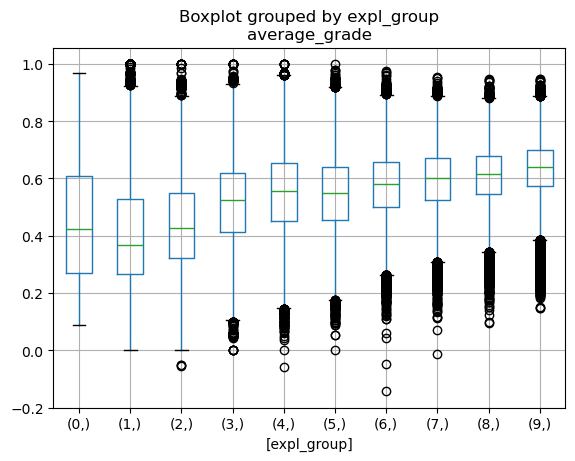

In [709]:
students.boxplot(column=['average_grade'], by=['expl_group'])

Просмотр объяснений начиная с 2 квартился существенно влияет на полученные оценки студентов.

In [729]:
students['average_time_for_question_seconds'] = students['average_time_for_question'].dt.total_seconds()

<Axes: xlabel='average_grade', ylabel='average_time_for_question_seconds'>

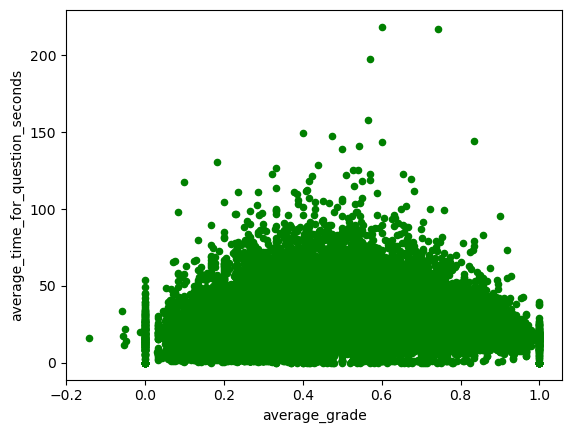

In [731]:
students.plot.scatter(x = 'average_grade', y = 'average_time_for_question_seconds', c = 'green')

Исходя из диаграммы рассеивания нельзя однозначно проследить зависимость затраченного времени на вопросв.

**Вывод**

* Часть студентов бросают учёбу в первые дни, вероятно из-за сложности вопросов или неодназначности материалов или просто что-то не нравится.
* Если студент потритл на учёбу более 40 часов, его оценки волзрастают более 0.5 и дальше только возрастает постепенно.
* Если курсы проходятся более чем полгода, то оценки становятся не стабильными.
* Анализ вопросв показал, что первые вопросы демотивируют обучающихся.
* С ростом кол-ва просмотренных объяснений устойчиво растет успеваемость студентов.
* Если студент посмотрит более 4х лекций, его успеваемость значительно возрастет. При этом просмотр более 11 лекций по какой-то причине не улучшает ситуацию.

##### Отдельные разделы

* part: номер темы/раздела* questions_num: кол-во ответов в каждом разделе,* questions_overall_answers: кол-во вопросов в разделеp* questions_correct_answers: кол-во правильных ответов в каждом разделе_* questions_success_rate: доля правильных ответов в каждом разделеc* lec_overall: кол-во лекций в каждом разделеn* lec_view: кол-во просмотров лекций в каждом разделеi* norm_lec_pop: нормализованная популярность лекций в каждом разделеc_pop_p

In [748]:
"""
Кол-во ответов в каждом разделе
"""
questions_num = questions.groupby('part')['question_id'].count()
questions_num

part
1     992
2    1647
3    1562
4    1439
5    5511
6    1211
7    1160
Name: question_id, dtype: int64

In [749]:
"""
Кол-во вопросов в разделе
"""
questions_overall_answers = questions_for_train.groupby('part')['overall_answers'].sum()
questions_overall_answers

part
1     7454570
2    18743404
3     8639907
4     8067676
5    40908153
6    10501471
7     4956118
Name: overall_answers, dtype: int64

In [750]:
"""
Кол-во правильных ответов в каждом разделе
"""
questions_correct_answers = questions_for_train.groupby('part')['correct_answers'].sum()
questions_correct_answers

part
1     5553896
2    13283339
3     6060514
4     5090684
5    24957570
6     7029562
7     3269061
Name: correct_answers, dtype: int64

In [776]:
"""
Доля правильных ответов в каждом разделе
"""
questions_success_rate = questions_for_train.groupby('part')['success_rate'].mean()
questions_success_rate

part
1    0.815104
2    0.745296
3    0.744598
4    0.724918
5    0.666119
6    0.699348
7    0.717958
Name: success_rate, dtype: float64

In [752]:
"""
Кол-во лекций в каждом разделе
"""
lec_overall = lectures.groupby('part')['lecture_id'].count()
lec_overall

part
1     54
2     56
3     19
4     31
5    143
6     83
7     32
Name: lecture_id, dtype: int64

In [757]:
"""
Кол-во просмотров лекций в каждом разделе
"""
lec_view = lectures_train.groupby('part')['lecture_count'].sum()
lec_view

part
1    173057
2    382129
3     99217
4     93078
5    934795
6    219726
7     57030
Name: lecture_count, dtype: int64

In [759]:
"""
Популярность лекций в каждом разделе
"""
lec_pop = [lectures_train[lectures_train.part == p]['lecture_count'].sum()/lectures_train[lectures_train.part == p]['lecture_id'].count() for p in range(1,8)]
lec_pop

[3204.759259259259,
 6823.732142857143,
 5221.9473684210525,
 3002.516129032258,
 6583.06338028169,
 2712.6666666666665,
 1782.1875]

In [765]:
"""
Нормализованная популярность лекций в каждом разделе
"""
norm_lec_pop = [round(pop / max(lec_pop), 3) for pop in lec_pop]
norm_lec_pop

[0.47, 1.0, 0.765, 0.44, 0.965, 0.398, 0.261]

In [778]:
"""
Запишем полученные данные в единую таблицу
"""
part_df = pd.DataFrame({'questions_num': questions_num,
                        'questions_overall_answers': questions_overall_answers,
                        'questions_correct_answers': questions_correct_answers,
                        'questions_success_rate': questions_success_rate,
                        'lec_overall': lec_overall,
                        'lec_view': lec_view,
                        'lec_pop': lec_pop,
                        'norm_lec_pop': norm_lec_pop
                       })
part_df

,questions_num,questions_overall_answers,questions_correct_answers,questions_success_rate,lec_overall,lec_view,lec_pop,norm_lec_pop
part,,,,,,,,
1,992,7454570,5553896,0.815104,54,173057,3204.759259,0.470
2,1647,18743404,13283339,0.745296,56,382129,6823.732143,1.000
3,1562,8639907,6060514,0.744598,19,99217,5221.947368,0.765
4,1439,8067676,5090684,0.724918,31,93078,3002.516129,0.440
5,5511,40908153,24957570,0.666119,143,934795,6583.063380,0.965
6,1211,10501471,7029562,0.699348,83,219726,2712.666667,0.398
7,1160,4956118,3269061,0.717958,32,57030,1782.187500,0.261


In [780]:
part_df.describe()

,questions_num,questions_overall_answers,questions_correct_answers,questions_success_rate,lec_overall,lec_view,lec_pop,norm_lec_pop
count,7.000000,7.000000e+00,7.000000e+00,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1931.714286,1.418161e+07,9.320661e+06,0.730478,59.714286,279861.714286,4190.124635,0.614143
std,1595.297226,1.256394e+07,7.580639e+06,0.046331,42.378117,308651.475293,2003.709255,0.293620
min,992.000000,4.956118e+06,3.269061e+06,0.666119,19.000000,57030.000000,1782.187500,0.261000
25%,1185.500000,7.761123e+06,5.322290e+06,0.708653,31.500000,96147.500000,2857.591398,0.419000
50%,1439.000000,8.639907e+06,6.060514e+06,0.724918,54.000000,173057.000000,3204.759259,0.470000
75%,1604.500000,1.462244e+07,1.015645e+07,0.744947,69.500000,300927.500000,5902.505374,0.865000
max,5511.000000,4.090815e+07,2.495757e+07,0.815104,143.000000,934795.000000,6823.732143,1.000000


In [782]:
part_df.sort_values(by='questions_success_rate', ascending=False)

,questions_num,questions_overall_answers,questions_correct_answers,questions_success_rate,lec_overall,lec_view,lec_pop,norm_lec_pop
part,,,,,,,,
1,992,7454570,5553896,0.815104,54,173057,3204.759259,0.470
2,1647,18743404,13283339,0.745296,56,382129,6823.732143,1.000
3,1562,8639907,6060514,0.744598,19,99217,5221.947368,0.765
4,1439,8067676,5090684,0.724918,31,93078,3002.516129,0.440
7,1160,4956118,3269061,0.717958,32,57030,1782.187500,0.261
6,1211,10501471,7029562,0.699348,83,219726,2712.666667,0.398
5,5511,40908153,24957570,0.666119,143,934795,6583.063380,0.965


**Вывод**

* Самая высокая средневзвешенная популярность у лекций 2 раздела.
* 5й раздел - самый насыщенный по материалу, 6й и 1й - более теоретические, а 3 и 4 - более прикладные.
* 5й раздел содержит максимальное число лекций и заданий, однако средняя успеваемость студентов для него самая низкая.
* По мере продвижения по разделам, сложность курса возрастает.
* Успеваемость по 4му и 6му разделу, можно улучшить, добавив в них качественные лекции.
* Успеваемостьпо 7му разделу, можно улучшить, добавив практические задания.